# Data Preprocessing

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo
- Eliardo Guimaraes da Costa

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PolyCollection, LineCollection

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20



def sm_plot(grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    plt.grid(grid, linestyle = ':', color = '0.50')
    # plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
    
    
def sm_plot_mod(ax, grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True,right = True, length = 5,width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8,width = 1, labelsize = 15)

---

## 1. Data Exploration

Reading river station, river-dam station and weather station data:

- **River station:** Kluserbrücke 
- **Weather station:** Wuppertal-Buchenhofen 
- **River-damn station:** Wupper-Talsperre 

**OBS:**

1. All `NaN` have been removed ;
2. All negative values have been removed .

In [3]:
# RIVER STATION
df_wl = pd.read_csv('Data/Wuppertal_data/2024_02_23__SKLU__ABF__2024-02-27.csv', sep = ',')
df_dis = pd.read_csv('Data/Wuppertal_data/2024_02_23__SKLU__WST__2024-02-27.csv', sep = ',')

df_wl = df_wl.rename(columns = {'result' : 'WATER-LEVEL'})
df_wl = df_wl.rename(columns = {'phenomenon time' : 'MESS_DATUM'})
df_wl.dropna()
df_dis = df_dis.rename(columns = {'result' : 'DISCHARGE'})
df_dis = df_dis.rename(columns = {'phenomenon time' : 'MESS_DATUM'})
df_dis.dropna()

df_wl = df_wl[df_wl['WATER-LEVEL'] >= 0]
df_dis = df_dis[df_dis['DISCHARGE'] >= 0]


# ---------------------------------------------------------------------------------------------------------------


# RIVER-DAM STATION
df_fl = pd.read_csv('Data/Wuppertal_data/2024_02_26__SWU$__SPF__2024-02-27.csv', sep = ',')
df_vol = pd.read_csv('Data/Wuppertal_data/2024_02_26__SWU$__SPI__2024-02-27.csv', sep = ',')

df_fl = df_fl.rename(columns = {'result' : 'FILL-LEVEL'})
df_fl = df_fl.rename(columns = {'phenomenon time' : 'MESS_DATUM'})
df_fl.dropna()
df_vol = df_vol.rename(columns = {'result' : 'VOLUME'})
df_vol = df_vol.rename(columns = {'phenomenon time' : 'MESS_DATUM'})
df_vol.dropna()

df_fl = df_fl[df_fl['FILL-LEVEL'] >= 0]
df_vol = df_vol[df_vol['VOLUME'] >= 0]


# ---------------------------------------------------------------------------------------------------------------


# WEATHER STATION
df_weather = pd.read_csv('Data/River-Weather_data/weather_data.csv', sep = ',')
mask = df_weather['STATIONS_NAME'] == 'Wuppertal-Buchenhofen'
df_weather = df_weather[mask]

cols_to_remove = ['STATIONS_NAME', 'STATIONS_ID', 'LATITUDE', 'LONGITUDE']
df_weather = df_weather.drop(columns = cols_to_remove)

- ### General Informations

In [4]:
print('River station: Kluserbrücke')
print('Weather station: Wuppertal-Buchenhofen')
print('River-damn station: Wupper-Talsperre')

print('')

print('Water-level:', df_wl.shape)
print('Discharge:', df_dis.shape)
print('Fill-level:', df_fl.shape)
print('Volume:', df_vol.shape)
print('Weather:', df_weather.shape)

River station: Kluserbrücke
Weather station: Wuppertal-Buchenhofen
River-damn station: Wupper-Talsperre

Water-level: (2191428, 2)
Discharge: (1451962, 2)
Fill-level: (178288, 2)
Volume: (178290, 2)
Weather: (12418, 8)


## 2. Date Format

1. Convert data format to `yyyy-mm-dd`;
2. Filter the dataframe to keep only measurements from `start_date` onwards;
3. Group by date and select the row with the highest measurement for each day.

In [5]:
def process_dataframe(df, date_column, value_column, start_date = '1990-01-01', 
                      weekly_average = False, monthly_average = False, aggregation_method = 'max'):
    # Ensure only one of weekly_average or monthly_average is True
    if weekly_average and monthly_average:
        raise ValueError("Only one of weekly_average or monthly_average can be True at a time.")
    
    # Ensure the aggregation_method is one of the allowed values
    if aggregation_method not in ['max', 'min', 'mean']:
        raise ValueError("aggregation_method must be 'max', 'min', or 'mean'.")

    # Convert date format to yyyy-mm-dd and filter the dataframe
    df[date_column] = pd.to_datetime(df[date_column]).dt.date
    df = df[df[date_column] >= pd.to_datetime(start_date).date()]
    
    # Group by date and aggregate based on the specified method
    if aggregation_method == 'max':
        df = df.loc[df.groupby(date_column)[value_column].idxmax()]
    elif aggregation_method == 'min':
        df = df.loc[df.groupby(date_column)[value_column].idxmin()]
    elif aggregation_method == 'mean':
        df = df.groupby(date_column).mean().reset_index()

    df.reset_index(drop = True, inplace = True)
    
    # Apply weekly averaging if specified
    if weekly_average:
        df[date_column] = pd.to_datetime(df[date_column])
        df = df.resample('W-MON', on = date_column).mean().reset_index()
        df[date_column] = df[date_column].dt.date

    # Apply monthly averaging if specified
    if monthly_average:
        df[date_column] = pd.to_datetime(df[date_column])
        df = df.resample('M', on = date_column).mean().reset_index()
        df[date_column] = df[date_column].dt.date
    
    return df

- Process the dataframes:

In [6]:
# GENERAL PROCESSING
df_wl = process_dataframe(df_wl, 'MESS_DATUM', 'WATER-LEVEL', aggregation_method = 'max')
df_dis = process_dataframe(df_dis, 'MESS_DATUM', 'DISCHARGE', aggregation_method = 'max')
df_fl = process_dataframe(df_fl, 'MESS_DATUM', 'FILL-LEVEL', aggregation_method = 'max')
df_vol = process_dataframe(df_vol, 'MESS_DATUM', 'VOLUME', aggregation_method = 'max')

# -----------------------------------------------------------------------------------------------------------

# WEEKLY AVERAGE
df_wl_weekly = process_dataframe(df_wl, 'MESS_DATUM', 'WATER-LEVEL', weekly_average = True, aggregation_method = 'mean')
df_dis_weekly = process_dataframe(df_dis, 'MESS_DATUM', 'DISCHARGE', weekly_average = True, aggregation_method = 'mean')
df_fl_weekly = process_dataframe(df_fl, 'MESS_DATUM', 'FILL-LEVEL', weekly_average = True, aggregation_method = 'mean')
df_vol_weekly = process_dataframe(df_vol, 'MESS_DATUM', 'VOLUME', weekly_average = True, aggregation_method = 'mean')

# -----------------------------------------------------------------------------------------------------------

# MONTHLY AVERAGE
df_wl_monthly = process_dataframe(df_wl, 'MESS_DATUM', 'WATER-LEVEL', monthly_average = True, aggregation_method = 'mean')
df_dis_monthly = process_dataframe(df_dis, 'MESS_DATUM', 'DISCHARGE', monthly_average = True, aggregation_method = 'mean')
df_fl_monthly = process_dataframe(df_fl, 'MESS_DATUM', 'FILL-LEVEL', monthly_average = True, aggregation_method = 'mean')
df_vol_monthly = process_dataframe(df_vol, 'MESS_DATUM', 'VOLUME', monthly_average = True, aggregation_method = 'mean')

## 3. Flooding Classification

- `WATER-LEVEL` $<90\implies\text{No Flood ;}$
- $90\leq$ `WATER-LEVEL` $<253\implies\text{Warning ;}$
- `WATER-LEVEL` $>253\implies\text{Alert .}$

In [7]:
def classify_flood(value):
    if value < 90:
        return 0
    elif 90 <= value < 253:
        return 1
    else:
        return 2
    
# ---------------------------------------------------------------------------------------------------------------
    
df_wl['FLOOD'] = df_wl['WATER-LEVEL'].apply(classify_flood)
df_wl_weekly['FLOOD'] = df_wl['WATER-LEVEL'].apply(classify_flood)
df_wl_monthly['FLOOD'] = df_wl['WATER-LEVEL'].apply(classify_flood)

## 4. Time Series Plot

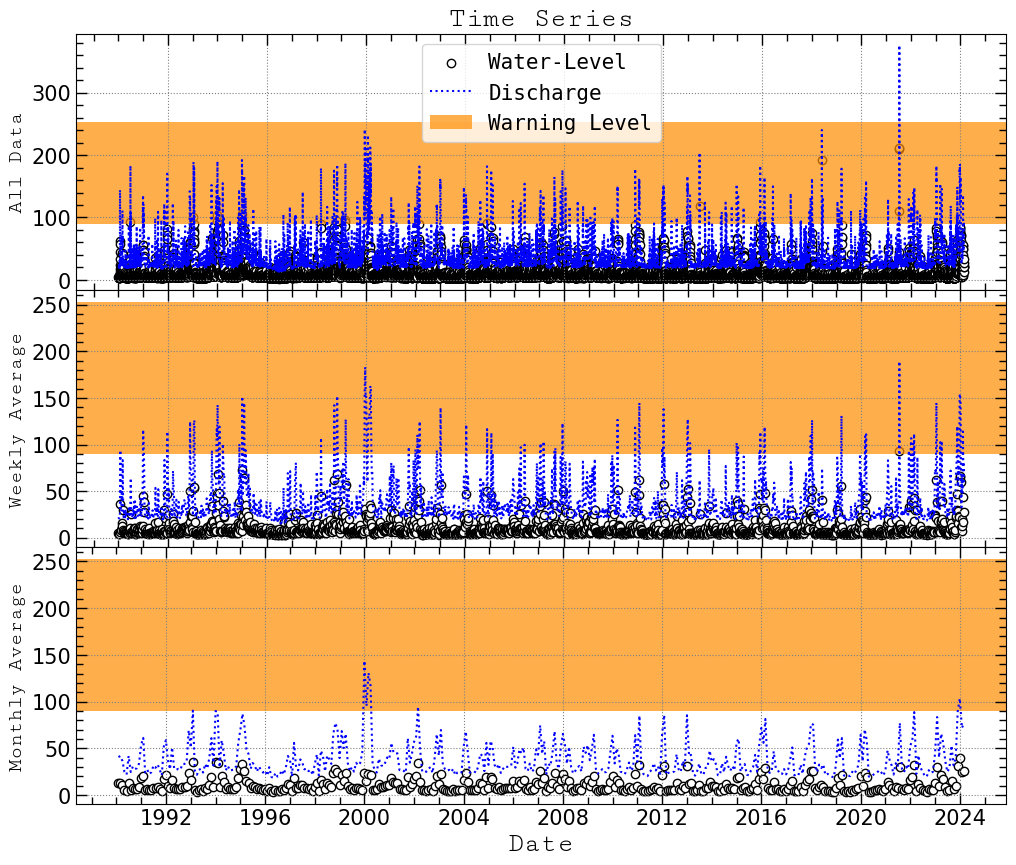

In [8]:
fig = plt.figure(figsize = (12,10))
fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 1, nrows = 3, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])
ax2 = fig.add_subplot(spec[2, 0])

ax0.scatter(df_wl['MESS_DATUM'], df_wl['WATER-LEVEL'], label = 'Water-Level',
           color = 'w', edgecolor = 'k')
ax0.plot(df_dis['MESS_DATUM'], df_dis['DISCHARGE'], label = 'Discharge', color = 'b', ls = ':')
ax0.axhspan(90, 253, facecolor = 'darkorange', alpha = 0.7, label = 'Warning Level')


ax1.scatter(df_wl_weekly['MESS_DATUM'], df_wl_weekly['WATER-LEVEL'], label = 'Water-Level',
           color = 'w', edgecolor = 'k')
ax1.plot(df_dis_weekly['MESS_DATUM'], df_dis_weekly['DISCHARGE'], label = 'Discharge', color = 'b', ls = ':')
ax1.axhspan(90, 253, facecolor = 'darkorange', alpha = 0.7, label = 'Warning Level')


ax2.scatter(df_wl_monthly['MESS_DATUM'], df_wl_monthly['WATER-LEVEL'], label = 'Water-Level',
           color = 'w', edgecolor = 'k')
ax2.plot(df_dis_monthly['MESS_DATUM'], df_dis_monthly['DISCHARGE'], label = 'Discharge', color = 'b', ls = ':')
ax2.axhspan(90, 253, facecolor = 'darkorange', alpha = 0.7, label = 'Warning Level')


ax0.set_title('Time Series', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('All Data', fontproperties = cm_font, fontsize = 15)
ax1.set_ylabel('Weekly Average', fontproperties = cm_font, fontsize = 15)
ax2.set_ylabel('Monthly Average', fontproperties = cm_font, fontsize = 15)
ax2.set_xlabel('Date', fontproperties = cm_font, fontsize = cm_size)


sm_plot_mod(ax0)
sm_plot_mod(ax1)
sm_plot_mod(ax2)
ax0.legend(loc = 9)

plt.savefig('Plots/Time_Series_Preprocessing.png', dpi = 400)

## 5. Dataframe Master

- ### Pivotating

Since grouping tables using dates in the `yyyy-mm-dd` format leaves room for many errors and bugs, the ideal is to create a new column in the dataframes that will be joined so that it can serve as a reference for the pandas `merge()` command. To do this, we apply a process called **pivoting**. This process consists of creating a column that will serve as a pivot for pandas.

For this particular dataframe, pivoting consists of assigning a fixed numeric value to each specific day in the dataframe, i.e.

- `1990-01-01`$\implies \text{pivot }1$ ; 
- `1990-01-02`$\implies \text{pivot }2$ ; 
- `1990-01-03`$\implies \text{pivot }3$ ; \
$\qquad\vdots$
- `2023-12-31`$\implies \text{pivot }12418$ .

In [9]:
def pivot(df):
    df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format = '%Y-%m-%d')
    min_date = df['MESS_DATUM'].min()
    df['PIVOT'] = (df['MESS_DATUM'] - min_date).dt.days + 1
    
    return df

# Pivoting
df_wl = pivot(df_wl)
df_dis = pivot(df_dis)
df_weather = pivot(df_weather)

df_wl_weekly = pivot(df_wl_weekly)
df_dis_weekly = pivot(df_dis_weekly)

df_wl_monthly = pivot(df_wl_monthly)
df_dis_monthly = pivot(df_dis_monthly)

- **Dataframe with all data**

In [10]:
df_river = pd.merge(df_wl, df_dis, on = 'PIVOT', how = 'outer')
df_master = pd.merge(df_river, df_weather, on = 'PIVOT', how = 'outer')

columns_to_remove = ['MESS_DATUM_x', 'MESS_DATUM_y']
df_master = df_master.drop(columns_to_remove, axis = 1)

# Moving the FLOOD & PIVOT columns to the end of the dataframe
flood_col = df_master.pop('FLOOD')
pivot_col = df_master.pop('PIVOT')
df_master['FLOOD'] = flood_col
df_master['PIVOT'] = pivot_col

# Moving the DATE column to the begining of the dataframe
cols_date = df_master.columns.tolist()
cols_date.remove('MESS_DATUM')
cols_date.insert(0, 'MESS_DATUM')
df_master = df_master[cols_date]

# Removing all NaNs in the dataframe
df_master = df_master.dropna()
df_master['FLOOD'] = df_master['FLOOD'].astype(int)

display(df_master)
print('Master:', df_master.shape)

# Saving the dataframes
df_master.to_csv('Reduced_Data/data_reduced.csv', index = False)
df_master.to_excel('Reduced_Data/data_reduced.xlsx', index = False)

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RS1,RS2,RS3,RS7,RS14,RSF,FLOOD,PIVOT
0,1990-01-01,4.548,22.0,0.1,0.102790,0.081214,0.000000,0.453204,6.117234,6.0,0,1
1,1990-01-03,4.548,22.0,0.0,0.000000,0.094785,0.079725,0.000000,2.474654,0.0,0,3
2,1990-01-04,4.548,22.0,0.0,0.082889,0.044273,0.000000,0.000000,0.000000,6.0,0,4
3,1990-01-06,3.799,20.0,0.0,0.000000,0.342618,2.186802,0.570589,0.720364,0.0,0,6
4,1990-01-07,3.799,20.0,0.0,1.056505,1.917828,0.787566,0.306570,0.848258,0.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
12065,2023-12-27,77.293,172.9,2.8,0.000000,13.805612,17.251582,27.545747,8.409038,4.0,0,12414
12066,2023-12-28,70.436,161.4,0.3,12.782493,0.592617,1.429676,12.063629,9.029170,4.0,0,12415
12067,2023-12-29,66.657,154.9,17.6,10.346342,0.000000,6.685611,0.813981,4.013248,4.0,0,12416
12068,2023-12-30,60.286,143.7,0.1,1.598052,5.983179,19.987744,5.539653,1.975216,4.0,0,12417


Master: (12062, 12)


- **Dataframe with weekly averages:**

In [11]:
df_river_weekly = pd.merge(df_wl_weekly, df_dis_weekly, on = 'PIVOT', how = 'outer')
df_master_weekly = pd.merge(df_river_weekly, df_weather, on = 'PIVOT', how = 'outer')

columns_to_remove = ['MESS_DATUM_x', 'MESS_DATUM_y']
df_master_weekly = df_master_weekly.drop(columns_to_remove, axis = 1)

# Moving the FLOOD & PIVOT columns to the end of the dataframe
flood_col = df_master_weekly.pop('FLOOD')
pivot_col = df_master_weekly.pop('PIVOT')
df_master_weekly['FLOOD'] = flood_col
df_master_weekly['PIVOT'] = pivot_col

# Moving the DATE column to the begining of the dataframe
cols_date = df_master_weekly.columns.tolist()
cols_date.remove('MESS_DATUM')
cols_date.insert(0, 'MESS_DATUM')
df_master_weekly = df_master_weekly[cols_date]

# Removing all NaNs in the dataframe
df_master_weekly = df_master_weekly.dropna()
df_master_weekly['FLOOD'] = df_master_weekly['FLOOD'].astype(int)

display(df_master_weekly)
print('Master:', df_master_weekly.shape)

# Saving the dataframes
df_master_weekly.to_csv('Reduced_Data/data_reduced_weekly.csv', index = False)
df_master_weekly.to_excel('Reduced_Data/data_reduced_weekly.xlsx', index = False)

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RS1,RS2,RS3,RS7,RS14,RSF,FLOOD,PIVOT
0,1990-01-01,4.548000,22.000000,0.1,0.102790,0.081214,0.000000,0.453204,6.117234,6.0,0,1
1,1990-01-08,4.108000,20.800000,1.1,2.064946,1.665509,0.091420,3.867121,1.132388,6.0,0,8
2,1990-01-15,4.249667,20.666667,8.6,6.968063,2.822125,0.845766,0.000000,0.000000,6.0,0,15
3,1990-01-22,6.136571,24.571429,3.4,47.159367,33.829964,2.148844,0.000000,0.000000,6.0,0,22
4,1990-01-29,35.915429,94.000000,0.0,0.000000,0.000000,0.000000,0.303511,4.296026,0.0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,2023-11-27,28.192286,84.428571,20.7,10.804154,1.477480,0.000000,4.667165,3.273079,4.0,0,12384
1770,2023-12-04,15.339714,54.428571,11.3,11.013541,6.702917,0.457877,1.755065,1.315749,4.0,0,12391
1771,2023-12-11,23.771286,75.100000,2.7,5.097600,7.233048,0.783505,0.481689,13.781423,4.0,0,12398
1772,2023-12-18,21.818714,69.800000,0.2,23.704913,4.961268,33.945808,16.791880,15.775617,4.0,0,12405


Master: (1774, 12)


- **Dataframe with monthly averages:**

In [12]:
df_river_monthly = pd.merge(df_wl_monthly, df_dis_monthly, on = 'PIVOT', how = 'outer')
df_master_monthly = pd.merge(df_river_monthly, df_weather, on = 'PIVOT', how = 'outer')

columns_to_remove = ['MESS_DATUM_x', 'MESS_DATUM_y']
df_master_monthly = df_master_monthly.drop(columns_to_remove, axis = 1)

# Moving the FLOOD & PIVOT columns to the end of the dataframe
flood_col = df_master_monthly.pop('FLOOD')
pivot_col = df_master_monthly.pop('PIVOT')
df_master_monthly['FLOOD'] = flood_col
df_master_monthly['PIVOT'] = pivot_col

# Moving the DATE column to the begining of the dataframe
cols_date = df_master_monthly.columns.tolist()
cols_date.remove('MESS_DATUM')
cols_date.insert(0, 'MESS_DATUM')
df_master_monthly = df_master_monthly[cols_date]

# Removing all NaNs in the dataframe
df_master_monthly = df_master_monthly.dropna()
df_master_monthly['FLOOD'] = df_master_monthly['FLOOD'].astype(int)

display(df_master_monthly)
print('Master:', df_master_monthly.shape)

# Saving the dataframes
df_master_monthly.to_csv('Reduced_Data/data_reduced_monthly.csv', index = False)
df_master_monthly.to_excel('Reduced_Data/data_reduced_monthly.xlsx', index = False)

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RS1,RS2,RS3,RS7,RS14,RSF,FLOOD,PIVOT
0,1990-01-01,12.951786,40.821429,0.1,0.102790,0.081214,0.000000,0.453204,6.117234,6.0,0,1
1,1990-01-29,13.044115,41.846154,0.0,0.000000,0.000000,0.000000,0.303511,4.296026,0.0,0,29
2,1990-03-01,10.582036,36.500000,1.4,2.430143,1.934631,3.889257,5.430673,0.000000,8.0,0,60
3,1990-03-31,5.573519,24.923077,0.0,0.000000,0.000000,4.056357,4.583380,2.519275,0.0,0,90
4,1990-05-01,4.549696,22.000000,0.0,0.000000,0.000000,0.000000,0.016784,0.000000,0.0,0,121
...,...,...,...,...,...,...,...,...,...,...,...,...
403,2023-08-01,15.228097,53.019355,2.6,8.941441,14.127583,7.994549,4.203575,7.615328,4.0,0,12266
404,2023-08-31,6.963533,31.950000,0.0,0.000000,16.317539,0.000000,0.000000,0.000000,0.0,0,12296
405,2023-10-01,10.024387,39.674194,0.0,0.000000,6.156723,1.415684,0.076149,0.240021,0.0,0,12327
406,2023-10-31,31.163900,89.453333,10.1,1.897765,0.040762,2.254868,0.000000,11.087220,4.0,0,12357


Master: (408, 12)


---